<a href="https://colab.research.google.com/github/m7saikat/IE-7374/blob/master/Lab_5_1_Black_Jack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Black Jack - Monte Carlo

### Importing Libraries


#### **Description of additional libraries used in this lab**

For this lab we need the following additional libraries.

* **sys** : We use this library to print the number of episodes the game is played
* **gym** : Toolkit to develop RL algorithms and generate RL environments.
* **defaultdict**: A defaultdict works exactly like a normal dict, but it is initialized with a function that takes no arguments and provides the default value for a nonexistent key. A sample example id provided below:-
* **Axes3D**: Python library to plot 3D images.


In [0]:
import sys
import gym

import numpy as np
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


### 1.Creating gym environment
* **Gym**: gym is an open-source RL toolkit which helpes simulating a lot of RL scenarios. Gym can provide us environments for all the labs that we have covered till now. The documentation for gym can be found [here](https://gym.openai.com/docs/). 

>In this lab we have used `gym` to get a environmental setup of the blackjack game. This is the github [link](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) to the code for the blackjack environment.

In [16]:
# Generate the env
env = gym.make('Blackjack-v0')
# i.e., we can see total number of action in Blackjack
env.action_space.n

2

### 2. Playing each game of black jack : Playing a single game of blackjack



In [0]:
def play_episode(env):
    episode = []
    state = env.reset()
    while True:
        # If the players hand is more than 18, then the probability that he 
        # would stick is .8 and if it is < 18 the probabliity that he would 
        # stick is .2
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]

        # Randomly chooses an action in between [0,1] i.e in between stick and hit
        action = np.random.choice(np.arange(2), p=probs)

        # Get the next state of card, associated reward(-1 or 0) and 
        next_state, reward, done, _ = env.step(action)

        # if game status(over or not) from the environment.
        # Append the state, action and reward to the te episode array, which keeps log of every turn
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

### 3. Monte-carlo prediction (Episodic Tasks)
This is the primary method. Plays through several episodes of the environment. This function takes in the number of episodes, discount factor and the blackjack environment and runs a game for `num_epoisode` times. This function plays one game at a time. Having played that game, it runs the function to update Q value for that particular episode.

In [0]:
def mc_predict(env, num_episodes, gamma=1.0):
    # Array for storing/managing the total rewards for a state action pair
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))

    # Number of times we have seen the same action pair
    N = defaultdict(lambda: np.zeros(env.action_space.n))

    # Average return
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Printing the episode number during run time
    for i_episode in range(1, num_episodes+1):
        episode = play_episode(env)
        update_Q(episode, Q, returns_sum, N, gamma)
        
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
    return Q

Plays a single episode with a set policy in the environment given. Records the state, action and reward for each step and returns the all timesteps for the episode.

The `env.reset` function starts a fresh game of blackjack, and it returns the initial or starting state of the game.

The `env.step` function gets the next state of card, associated reward(-1 or 0) and if game status(over or not) from the environment.

### 3. Updating Q Value : 

For each time step in the episode we carry out the first visit monte carlo method, checking if this is the first index of this state. Get the discounted reward and add it to the total reward for that state/action pair. Increment the times we have seen this state action pair and finally update the Q values

In [0]:
def update_Q(episode, Q,returns_sum, N, gamma=1.0):
    for s, a, r in episode:
            # each eposidoe x contains x=(s,a,r), i.e x[0]=s
            # Using first visit approach: Obtain the index of the state s that visted for the first time in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == s)
            
            # Calculating the discounted rewards:  G <- γG + R(t+1)
            G = sum([x[2]*(gamma**i) for i,x in enumerate(episode[first_occurence_idx:])])

            # Updating and storing the total reward for a particular state action pair
            returns_sum[s][a] += G

            # Number of times we have seen the same action pair 
            N[s][a] += 1.0
            
            # Calculating average return
            Q[s][a] = returns_sum[s][a] / N[s][a]
        


### Function for plotting the result

In [0]:
def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

### Running the monte carlo update on 500000 episodes

Episode 500000/500000.

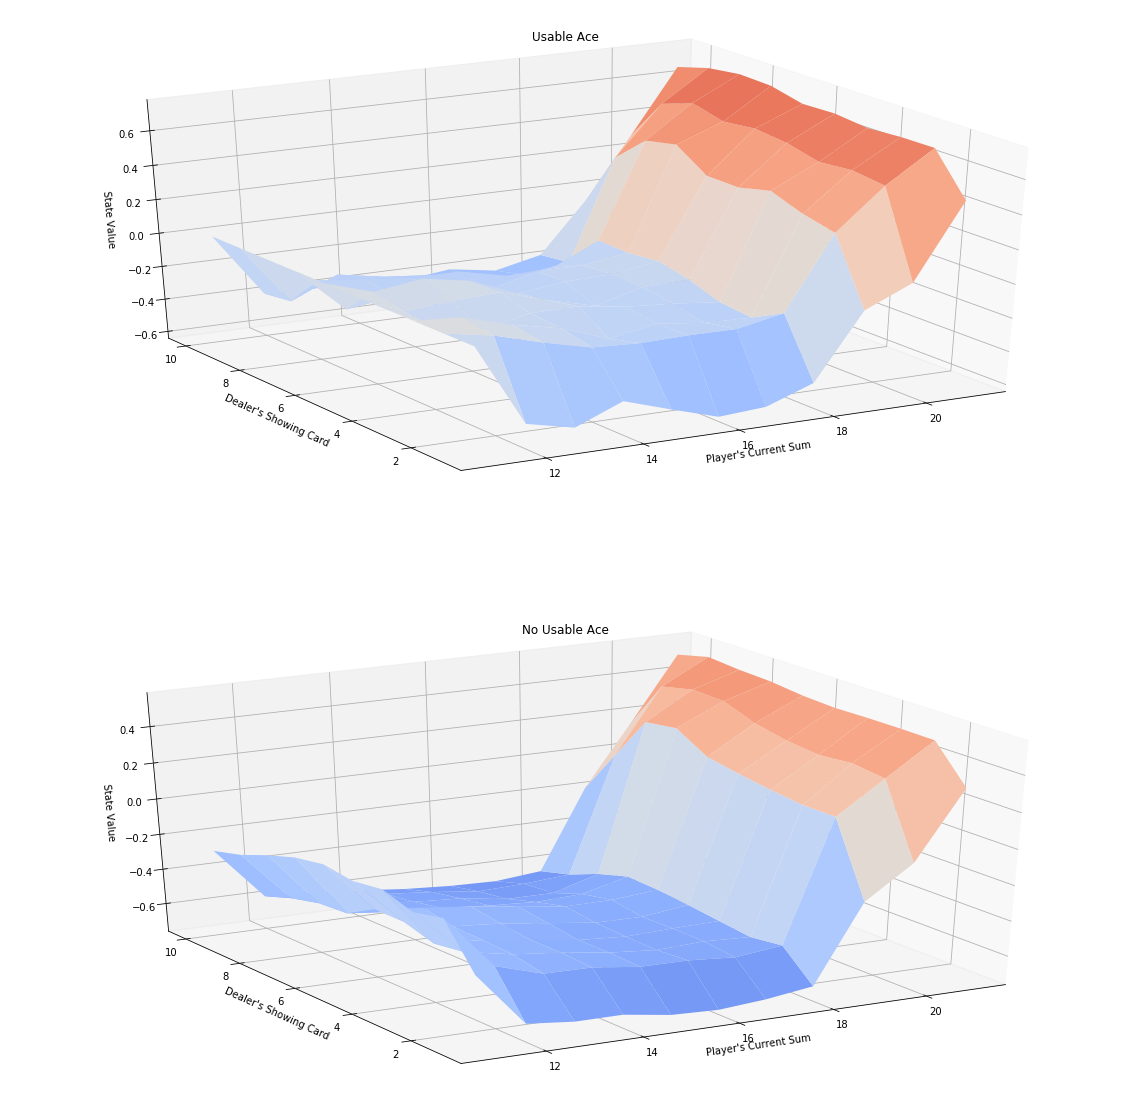

In [21]:

#predict the policy values for our test policy
Q = mc_predict(env, 500000)
#get the state value function for our test policy
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state value functions
plot_blackjack_values(V_to_plot)